In [1]:
# Trying to assert that the propagator is working as expected
# by propagating a rich quantum circuit with diverse observables
import pennylane as qml
from pprop.propagator import Propagator

n_qubits = 4

def ansatz(params):
    depth = 2  # Number of layers

    for q in range(n_qubits):
        qml.Hadamard(wires=q)

    idx = 0
    for d in range(depth):
        # Parameterized single-qubit rotations
        for q in range(n_qubits):
            qml.RX(params[idx], wires=q)
            idx += 1
            qml.RY(params[idx], wires=q)
            idx += 1
            qml.RZ(params[idx], wires=q)
            idx += 1

        # Entanglement layer (alternating pattern per depth)
        if d % 2 == 0:
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[2, 3])
            qml.CZ(wires=[1, 2])
        else:
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[3, 0])
            qml.CZ(wires=[0, 2])

    # Final layer of Hadamards
    for q in range(n_qubits):
        qml.Hadamard(wires=q)

    # Return expectation values of all qubits
    return [
        qml.expval(qml.PauliZ(0)), 
        qml.expval(qml.PauliZ(0)@qml.PauliZ(1)),
        qml.expval(qml.PauliZ(0)@qml.PauliX(1)@qml.PauliY(2)),
        qml.expval(qml.PauliX(1)@qml.PauliZ(3))
    ]

dev = qml.device('default.qubit', wires=n_qubits)
circuit = qml.QNode(ansatz, dev)

/home/samonaco/Projects/Pauli-Propagator/.venv/lib/python3.12/site-packages/pennylane/operation.py:2622: PennyLaneDeprecationWarning: Observable is deprecated and will be removed in v0.43. A generic Operator class should be used instead. If defining an Operator, set the is_hermitian property to True. If checking if an Operator is Hermitian, check the is_hermitian property. 
  warnings.warn(


In [2]:
propagator = Propagator(ansatz)

### Are we loading the same circuit?

(<Figure size 1600x500 with 1 Axes>, <Axes: >)

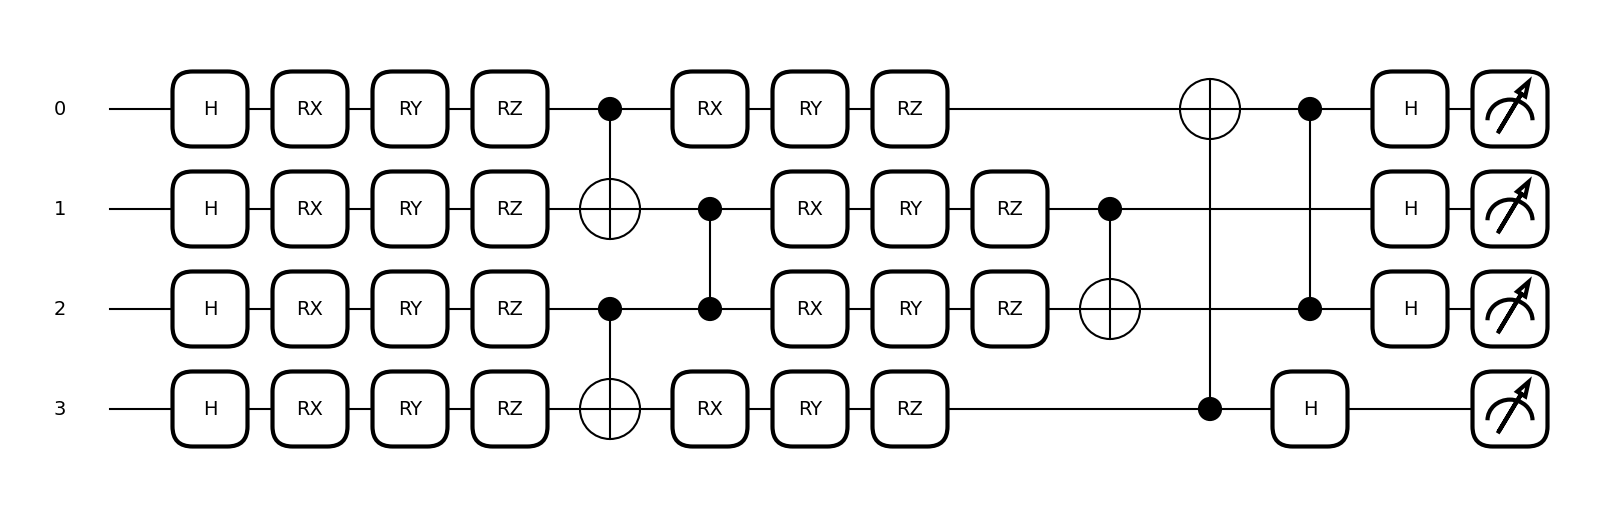

In [3]:
qml.draw_mpl(circuit)(qml.numpy.arange(100))

In [4]:
propagator

Propagator
  Number of qubits : 4
  Trainable parameters : 24
  Cutoff 1: None | Cutoff 2: None
  Observables [Z(0), (Z(0) @ Z(1)), (Z(0) @ X(1) @ Y(2)), (X(1) @ Z(3))]
0: ──H──RX──RY──RZ─╭●──RX──RY──RZ────────╭X─╭●──H─┤  <Z> ╭<Z@Z> ╭<Z@X@Y>       
1: ──H──RX──RY──RZ─╰X─╭●───RX──RY──RZ─╭●─│──│───H─┤      ╰<Z@Z> ├<Z@X@Y> ╭<X@Z>
2: ──H──RX──RY──RZ─╭●─╰Z───RX──RY──RZ─╰X─│──╰Z──H─┤             ╰<Z@X@Y> │     
3: ──H──RX──RY──RZ─╰X──RX──RY──RZ────────╰●──H────┤                      ╰<X@Z>

### Are we outputs the same?

In [5]:
# Propagate each observable
propagator.propagate()

# Convert the propagated result to a function
prop_func = propagator.lambdify()

Propagating (X(1) @ Z(3)): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]       


In [6]:
num_params = propagator.num_params

for i in range(100):
    params = qml.numpy.random.random(num_params)
    pennylane_result = circuit(params)
    propagated_result = prop_func(params)
    assert qml.math.allclose(pennylane_result, propagated_result)